<h2 align="center"> EXPLORATORY DATA ANALYSIS (EDA) NOTEBOOK </h2>

<h3 align="center">Multi-Scale Driver Interactions on Crop Phenology</h3>

<h4>============================================================</h4>
<h5>This notebook provides comprehensive EDA including:</h5>
<li align="center"> 1. Data distribution analysis</li>
<li align="center"> 2. Correlation matrices (Pearson & Spearman)</li>
<li align="center"> 3. Spatial visualization of key drivers</li>
<li align="center"> 4. Multi-scale pattern detection</li>
<li align="center"> 5. Feature importance via Random Forest</li>
<li align="center"> 6. Interaction detection</li>
<h4>============================================================</h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("EXPLORATORY DATA ANALYSIS: Multi-Scale Driver Interactions")
print("="*70)

EXPLORATORY DATA ANALYSIS: Multi-Scale Driver Interactions


#### ============================================================================
<h4 align="center"> SECTION 1: LOAD AND PREPARE DATA</h4>

#### ============================================================================

In [2]:
print("\n📂 Loading integrated dataset...")

# Load the processed data from previous extraction
data = pd.read_csv('./data_output/multiscale_integrated_data.csv')
print(f"✅ Data loaded: {data.shape}")
print(f"   Observations: {len(data)}")
print(f"   Features: {data.shape[1]}")

# Define feature categories for organized analysis
CLIMATE_FEATURES = ['temp_mean', 'temp_min', 'temp_max', 'temp_std',
                    'precip_total', 'precip_mean', 'precip_std',
                    'radiation_mean', 'dewpoint_mean', 'wind_mean', 'vpd']

SOIL_FEATURES = ['ph', 'clay', 'sand', 'silt', 'organic', 'nitrogen']

TOPO_FEATURES = ['elevation', 'slope', 'aspect', 'hillshade', 'tpi']

INTERACTION_FEATURES = ['temp_clay_interaction', 'precip_organic_interaction',
                        'temp_moisture_proxy', 'temp_elevation_interaction',
                        'precip_slope_interaction', 'sand_clay_ratio']

PHENOLOGY_FEATURES = ['ndvi_mean', 'ndvi_max', 'ndvi_min', 'ndvi_std',
                      'evi_mean', 'evi_max']

ALL_PREDICTORS = CLIMATE_FEATURES + SOIL_FEATURES + TOPO_FEATURES + INTERACTION_FEATURES
TARGET_VARIABLE = 'ndvi_max'  # Primary phenology metric

# Handle any missing values
print(f"\n🔍 Checking data quality...")
missing_summary = data[ALL_PREDICTORS + PHENOLOGY_FEATURES].isnull().sum()
if missing_summary.sum() > 0:
    print(f"⚠️  Found {missing_summary.sum()} missing values. Imputing with median...")
    data[ALL_PREDICTORS + PHENOLOGY_FEATURES] = data[ALL_PREDICTORS + PHENOLOGY_FEATURES].fillna(
        data[ALL_PREDICTORS + PHENOLOGY_FEATURES].median()
    )
else:
    print("✅ No missing values detected")


📂 Loading integrated dataset...
✅ Data loaded: (10000, 40)
   Observations: 10000
   Features: 40

🔍 Checking data quality...
⚠️  Found 33400 missing values. Imputing with median...


#### ============================================================================
<h4 align="center">SECTION 2: UNIVARIATE ANALYSIS</h4>

#### ============================================================================

✅ Climate feature distributions plotted
✅ Soil feature distributions plotted
✅ Topographic feature distributions plotted
✅ Phenology indicator distributions plotted


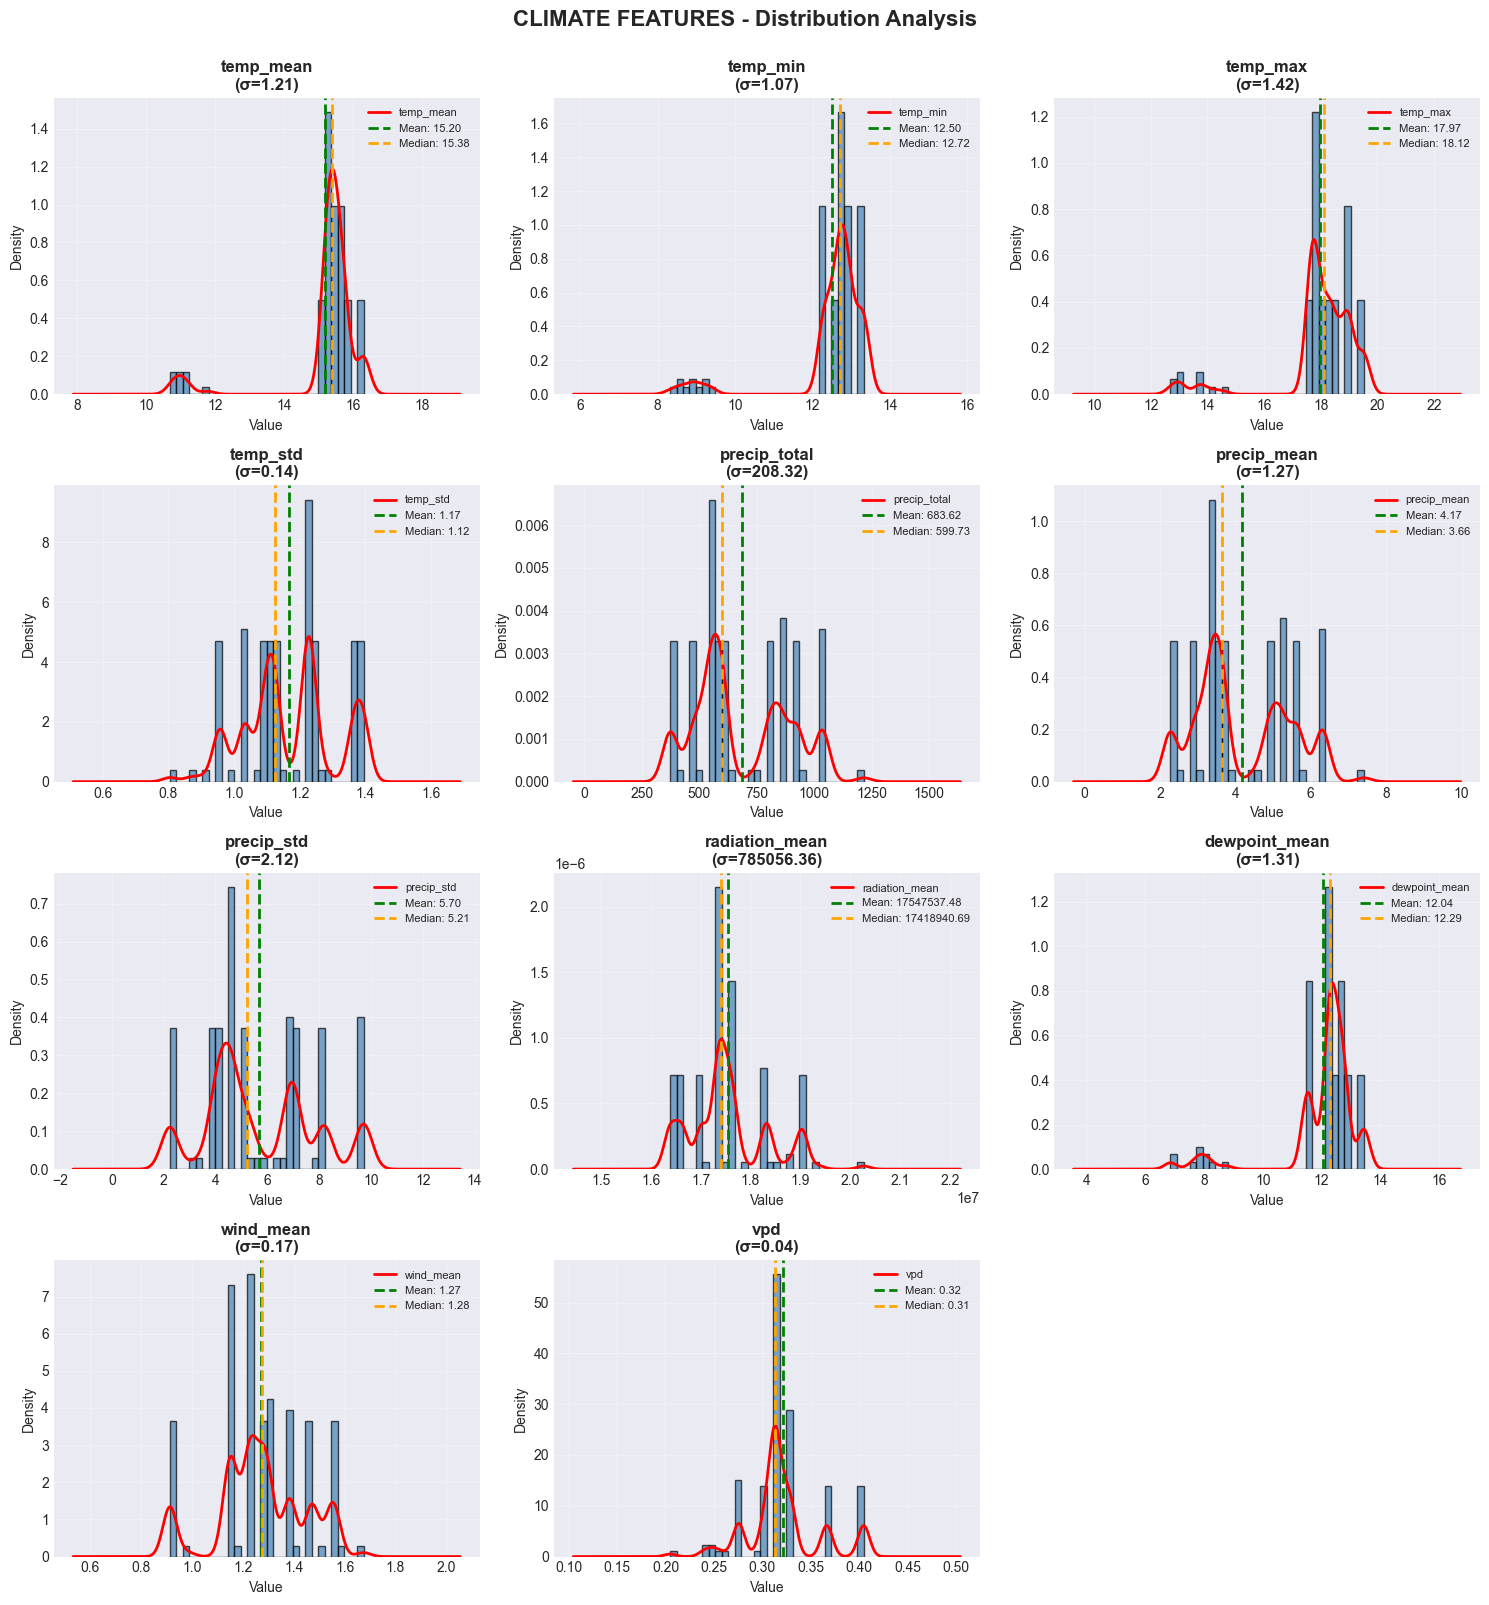

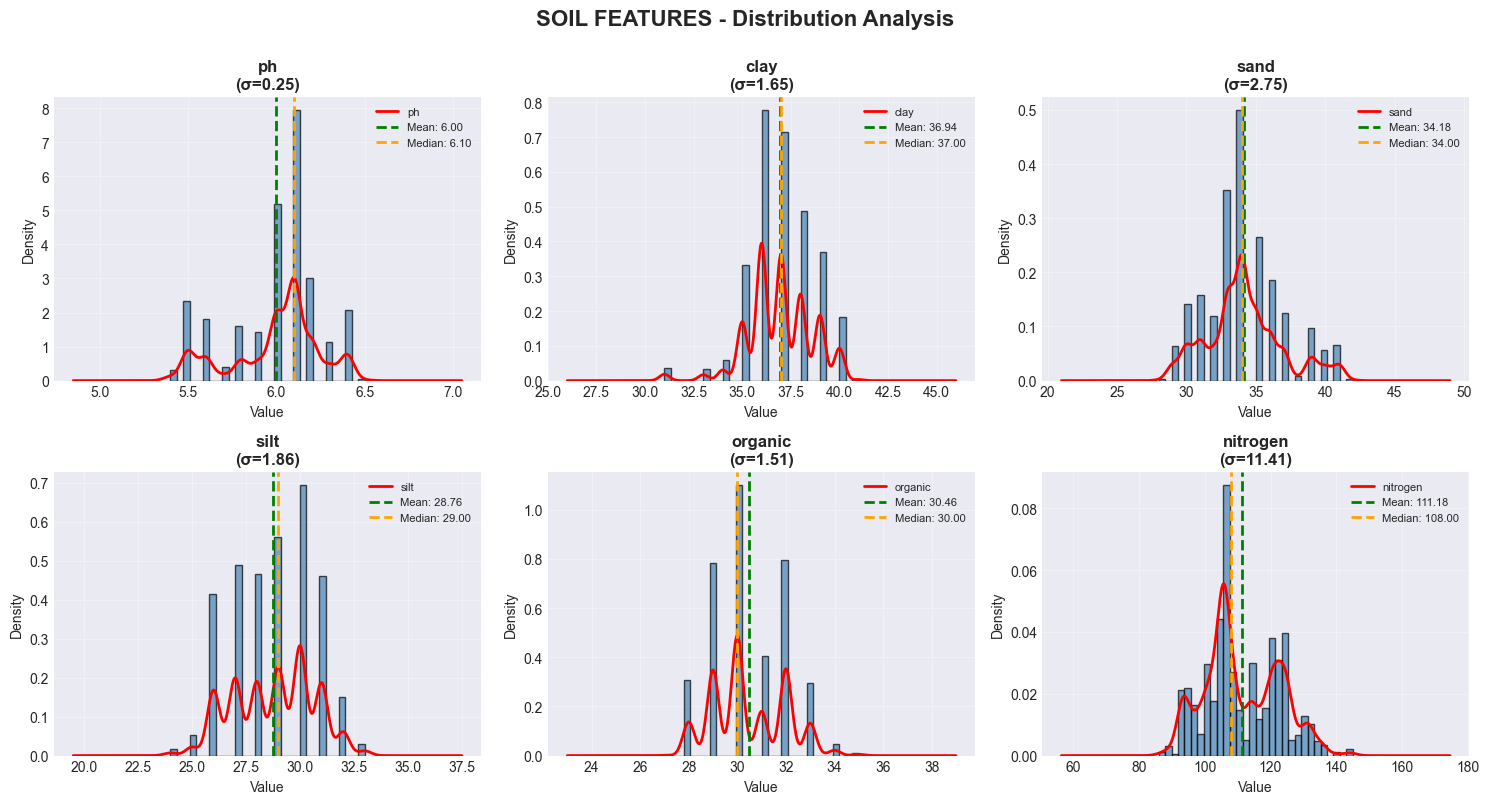

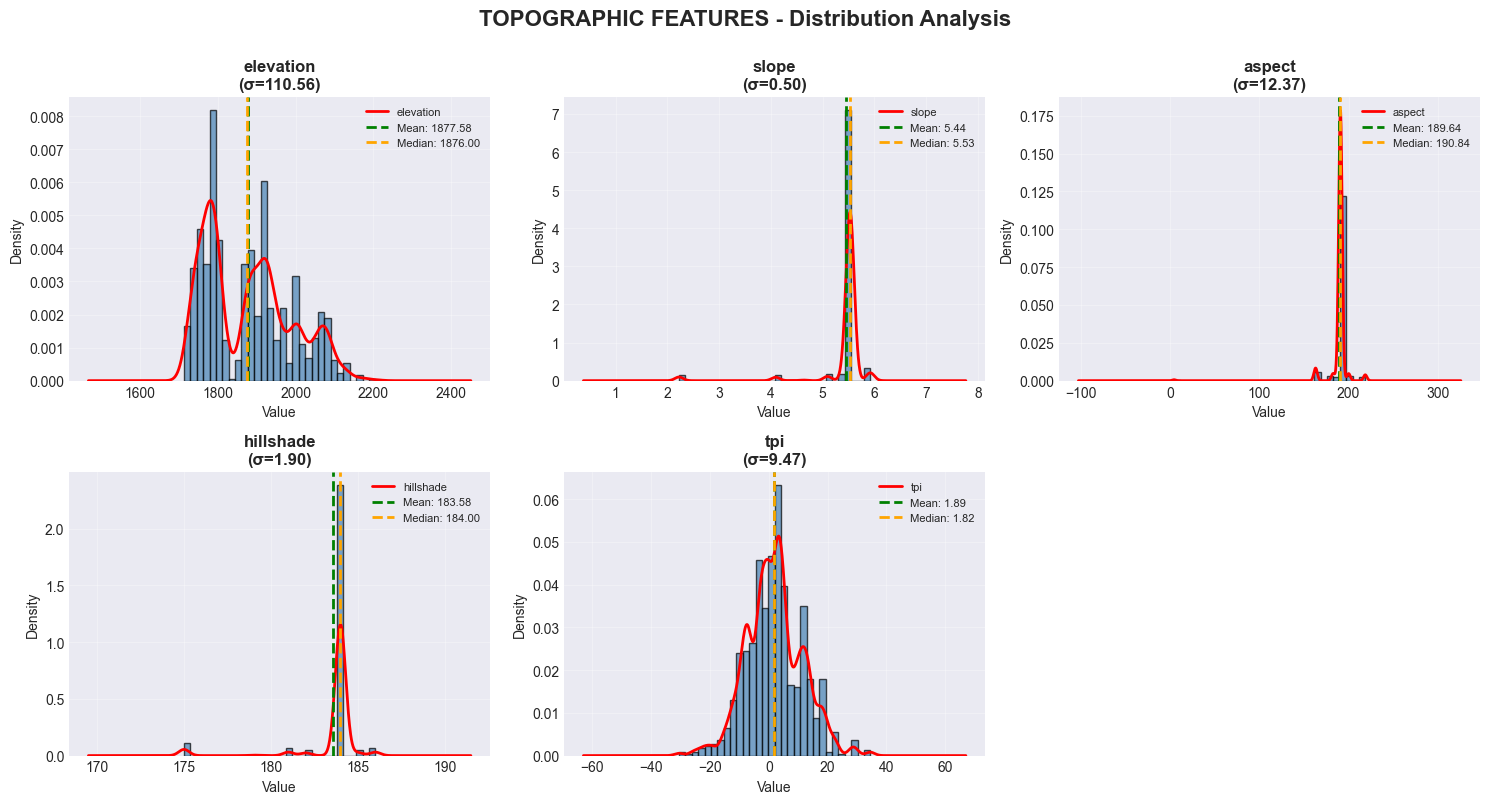

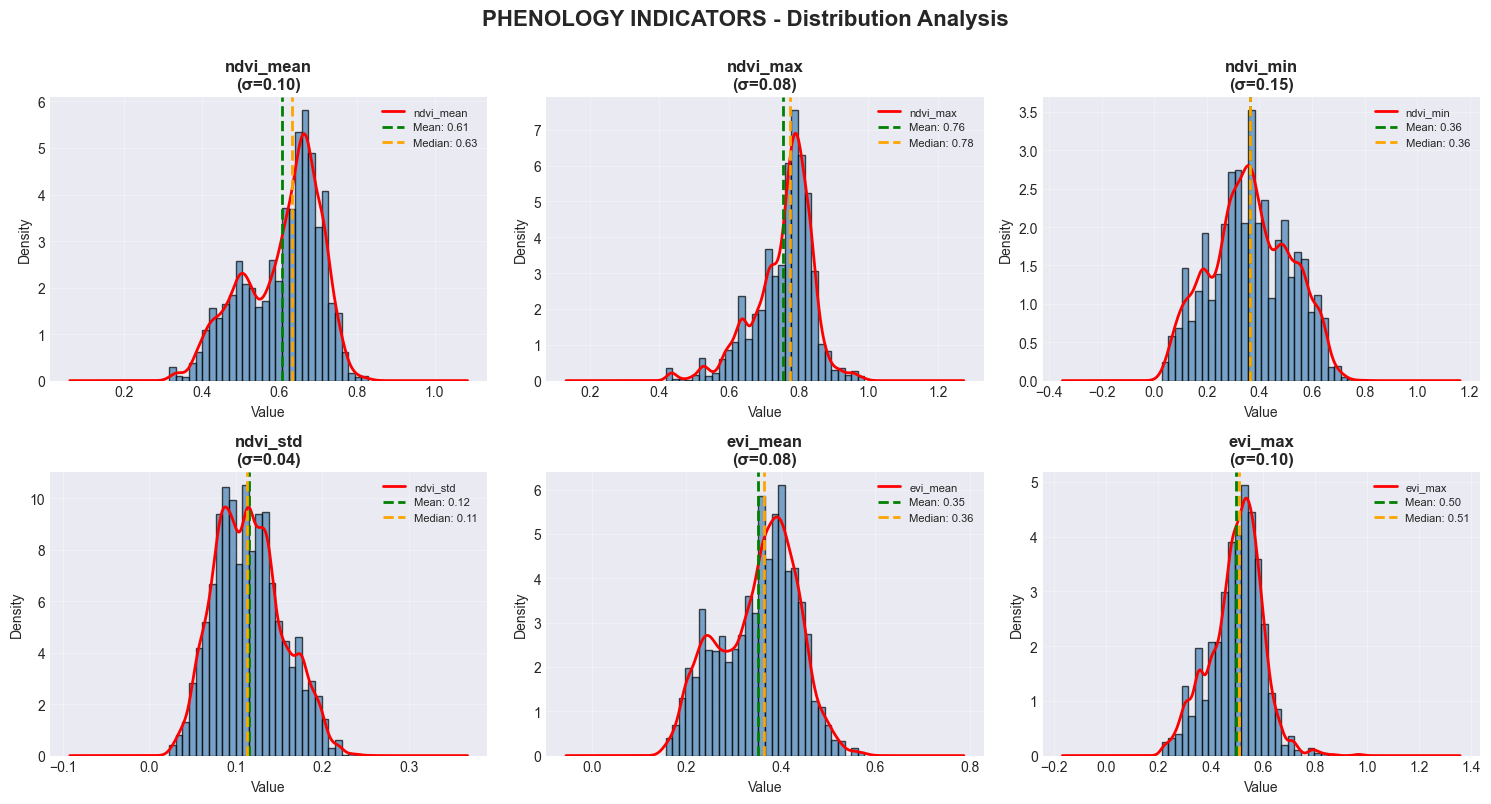

In [3]:
def plot_feature_distributions(data, features, category_name, ncols=3):
    """Plot distributions for a category of features"""
    nrows = int(np.ceil(len(features) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows*4))
    axes = axes.flatten() if len(features) > 1 else [axes]
    
    for idx, feature in enumerate(features):
        if idx < len(axes):
            ax = axes[idx]
            
            # Histogram with KDE
            ax.hist(data[feature].dropna(), bins=30, alpha=0.7, 
                   color='steelblue', edgecolor='black', density=True)
            
            # Add KDE
            data[feature].dropna().plot.kde(ax=ax, color='red', linewidth=2)
            
            # Statistics
            mean_val = data[feature].mean()
            median_val = data[feature].median()
            std_val = data[feature].std()
            
            ax.axvline(mean_val, color='green', linestyle='--', 
                      linewidth=2, label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='orange', linestyle='--', 
                      linewidth=2, label=f'Median: {median_val:.2f}')
            
            ax.set_title(f'{feature}\n(σ={std_val:.2f})', fontweight='bold')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    # Remove extra subplots
    for idx in range(len(features), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle(f'{category_name} - Distribution Analysis', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    return fig

# Plot distributions by category
fig1 = plot_feature_distributions(data, CLIMATE_FEATURES, 'CLIMATE FEATURES')
plt.savefig('./data_output/eda_climate_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Climate feature distributions plotted")

fig2 = plot_feature_distributions(data, SOIL_FEATURES, 'SOIL FEATURES', ncols=3)
plt.savefig('./data_output/eda_soil_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Soil feature distributions plotted")

fig3 = plot_feature_distributions(data, TOPO_FEATURES, 'TOPOGRAPHIC FEATURES', ncols=3)
plt.savefig('./data_output/eda_topo_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Topographic feature distributions plotted")

fig4 = plot_feature_distributions(data, PHENOLOGY_FEATURES, 'PHENOLOGY INDICATORS', ncols=3)
plt.savefig('./data_output/eda_phenology_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Phenology indicator distributions plotted")

#### ============================================================================
<h3 align="center">SECTION 3: CORRELATION ANALYSIS</h3>

#### ============================================================================

✅ Pearson correlation matrix plotted
✅ Spearman correlation matrix plotted
✅ Predictor-Phenology correlation plotted

📊 Top 15 correlations with ndvi_max:
evi_max                       0.879391
ndvi_mean                     0.847359
evi_mean                      0.832790
precip_organic_interaction    0.643033
precip_mean                   0.612596
precip_total                  0.612596
precip_std                    0.584071
temp_moisture_proxy           0.560559
nitrogen                      0.343472
organic                       0.330731
ndvi_min                      0.266418
ndvi_std                      0.237535
precip_slope_interaction      0.220501
silt                          0.190608
clay                          0.183143
Name: ndvi_max, dtype: float64


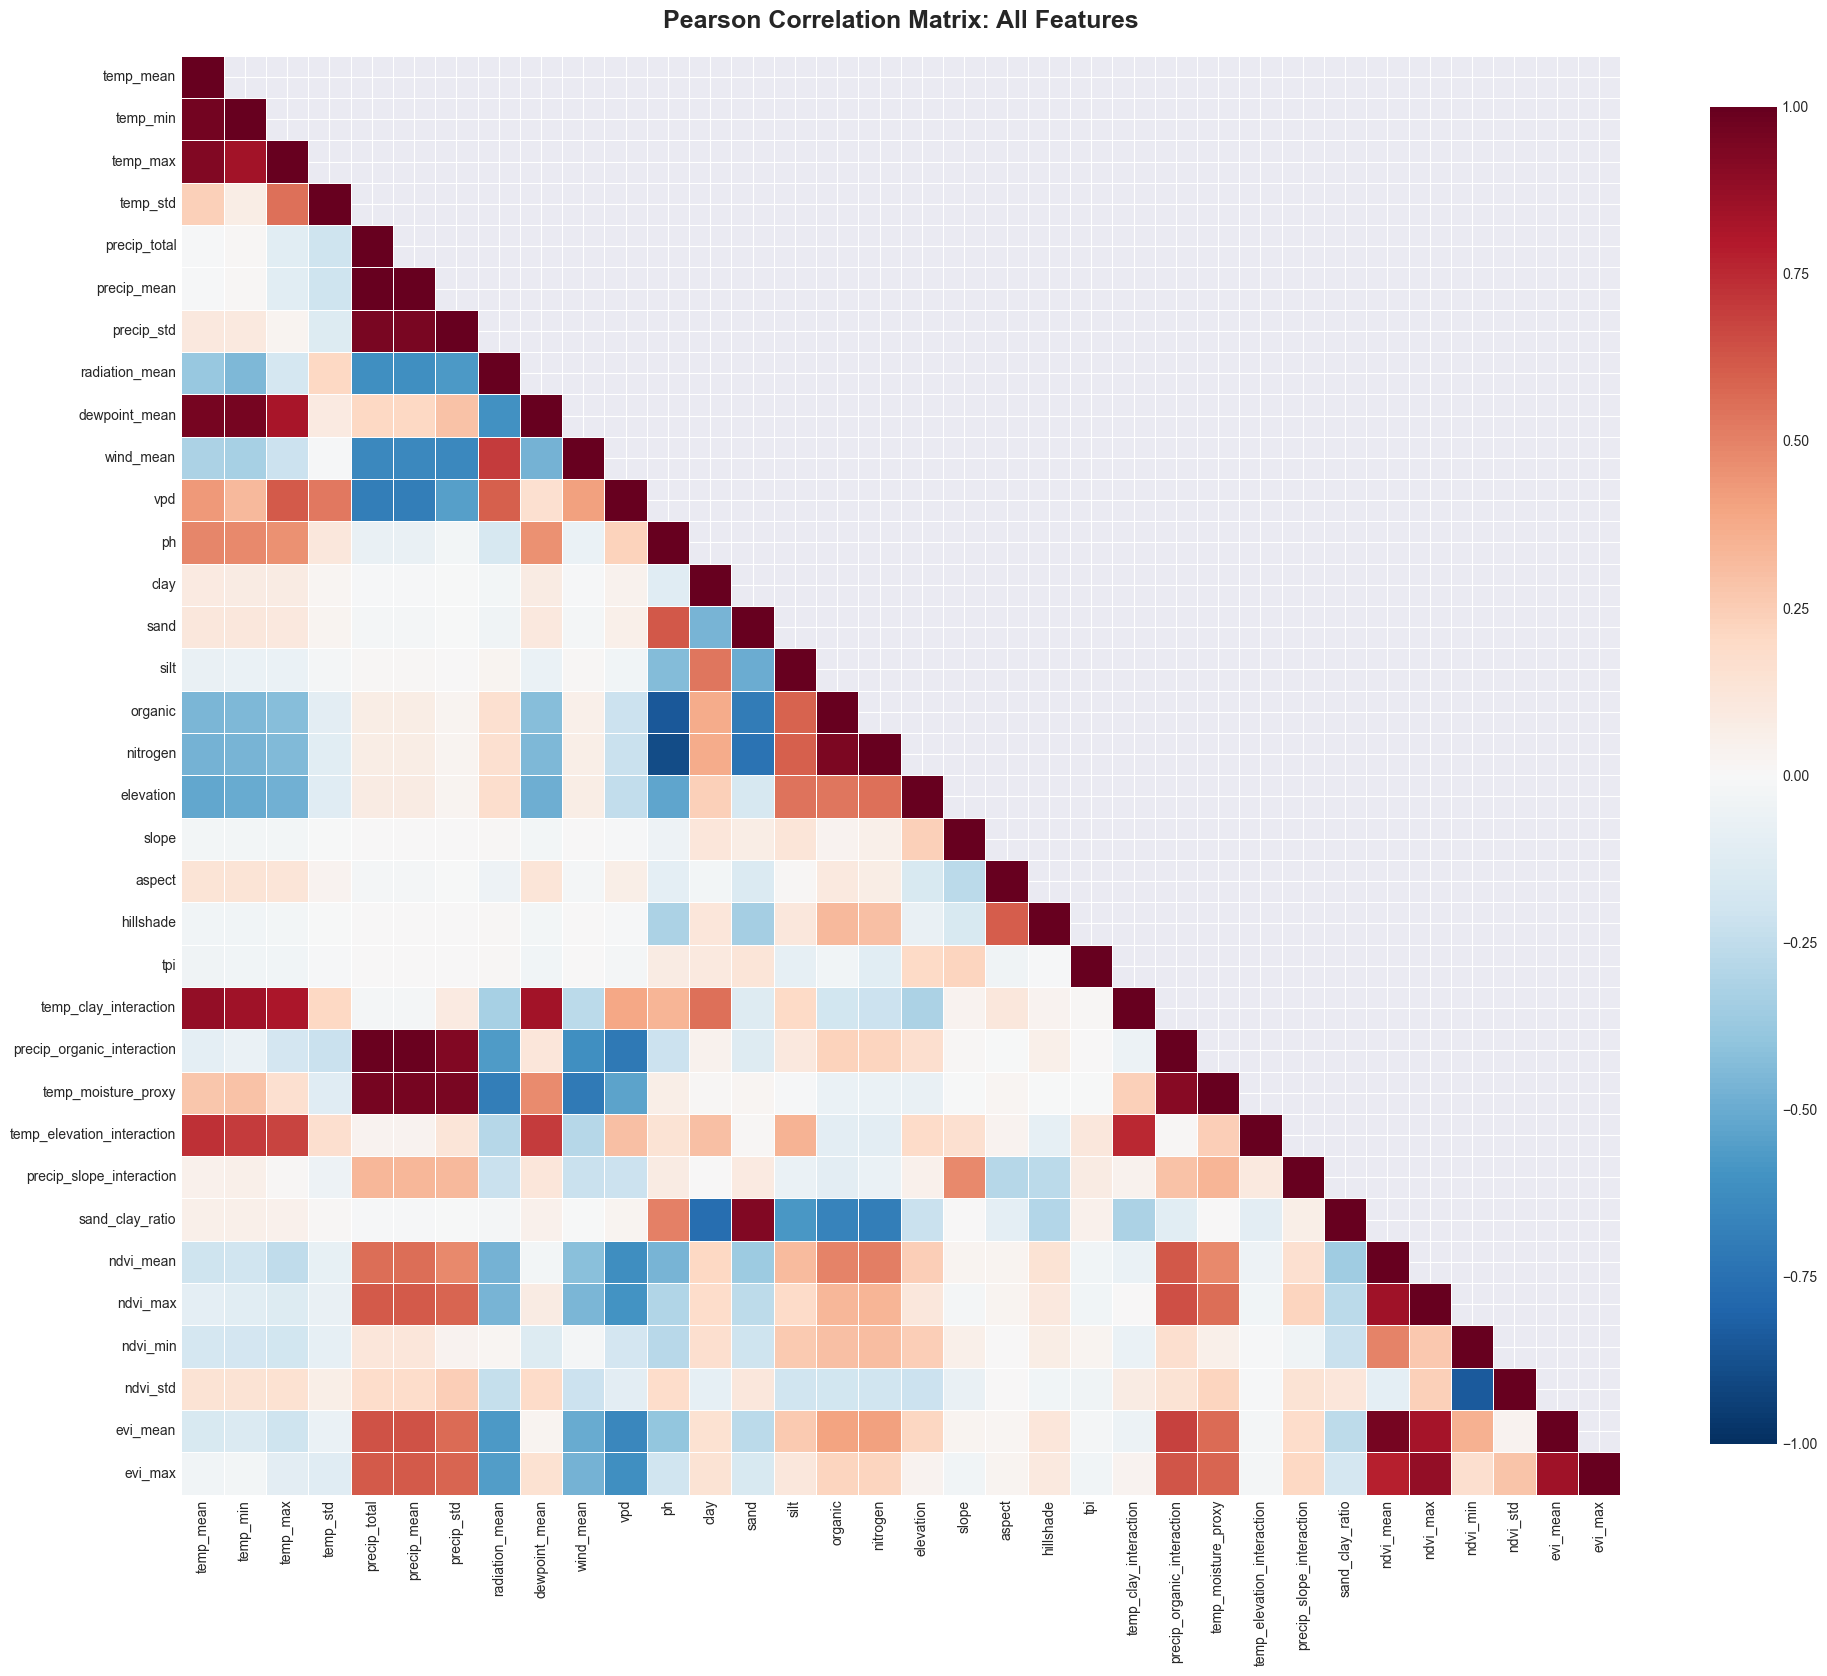

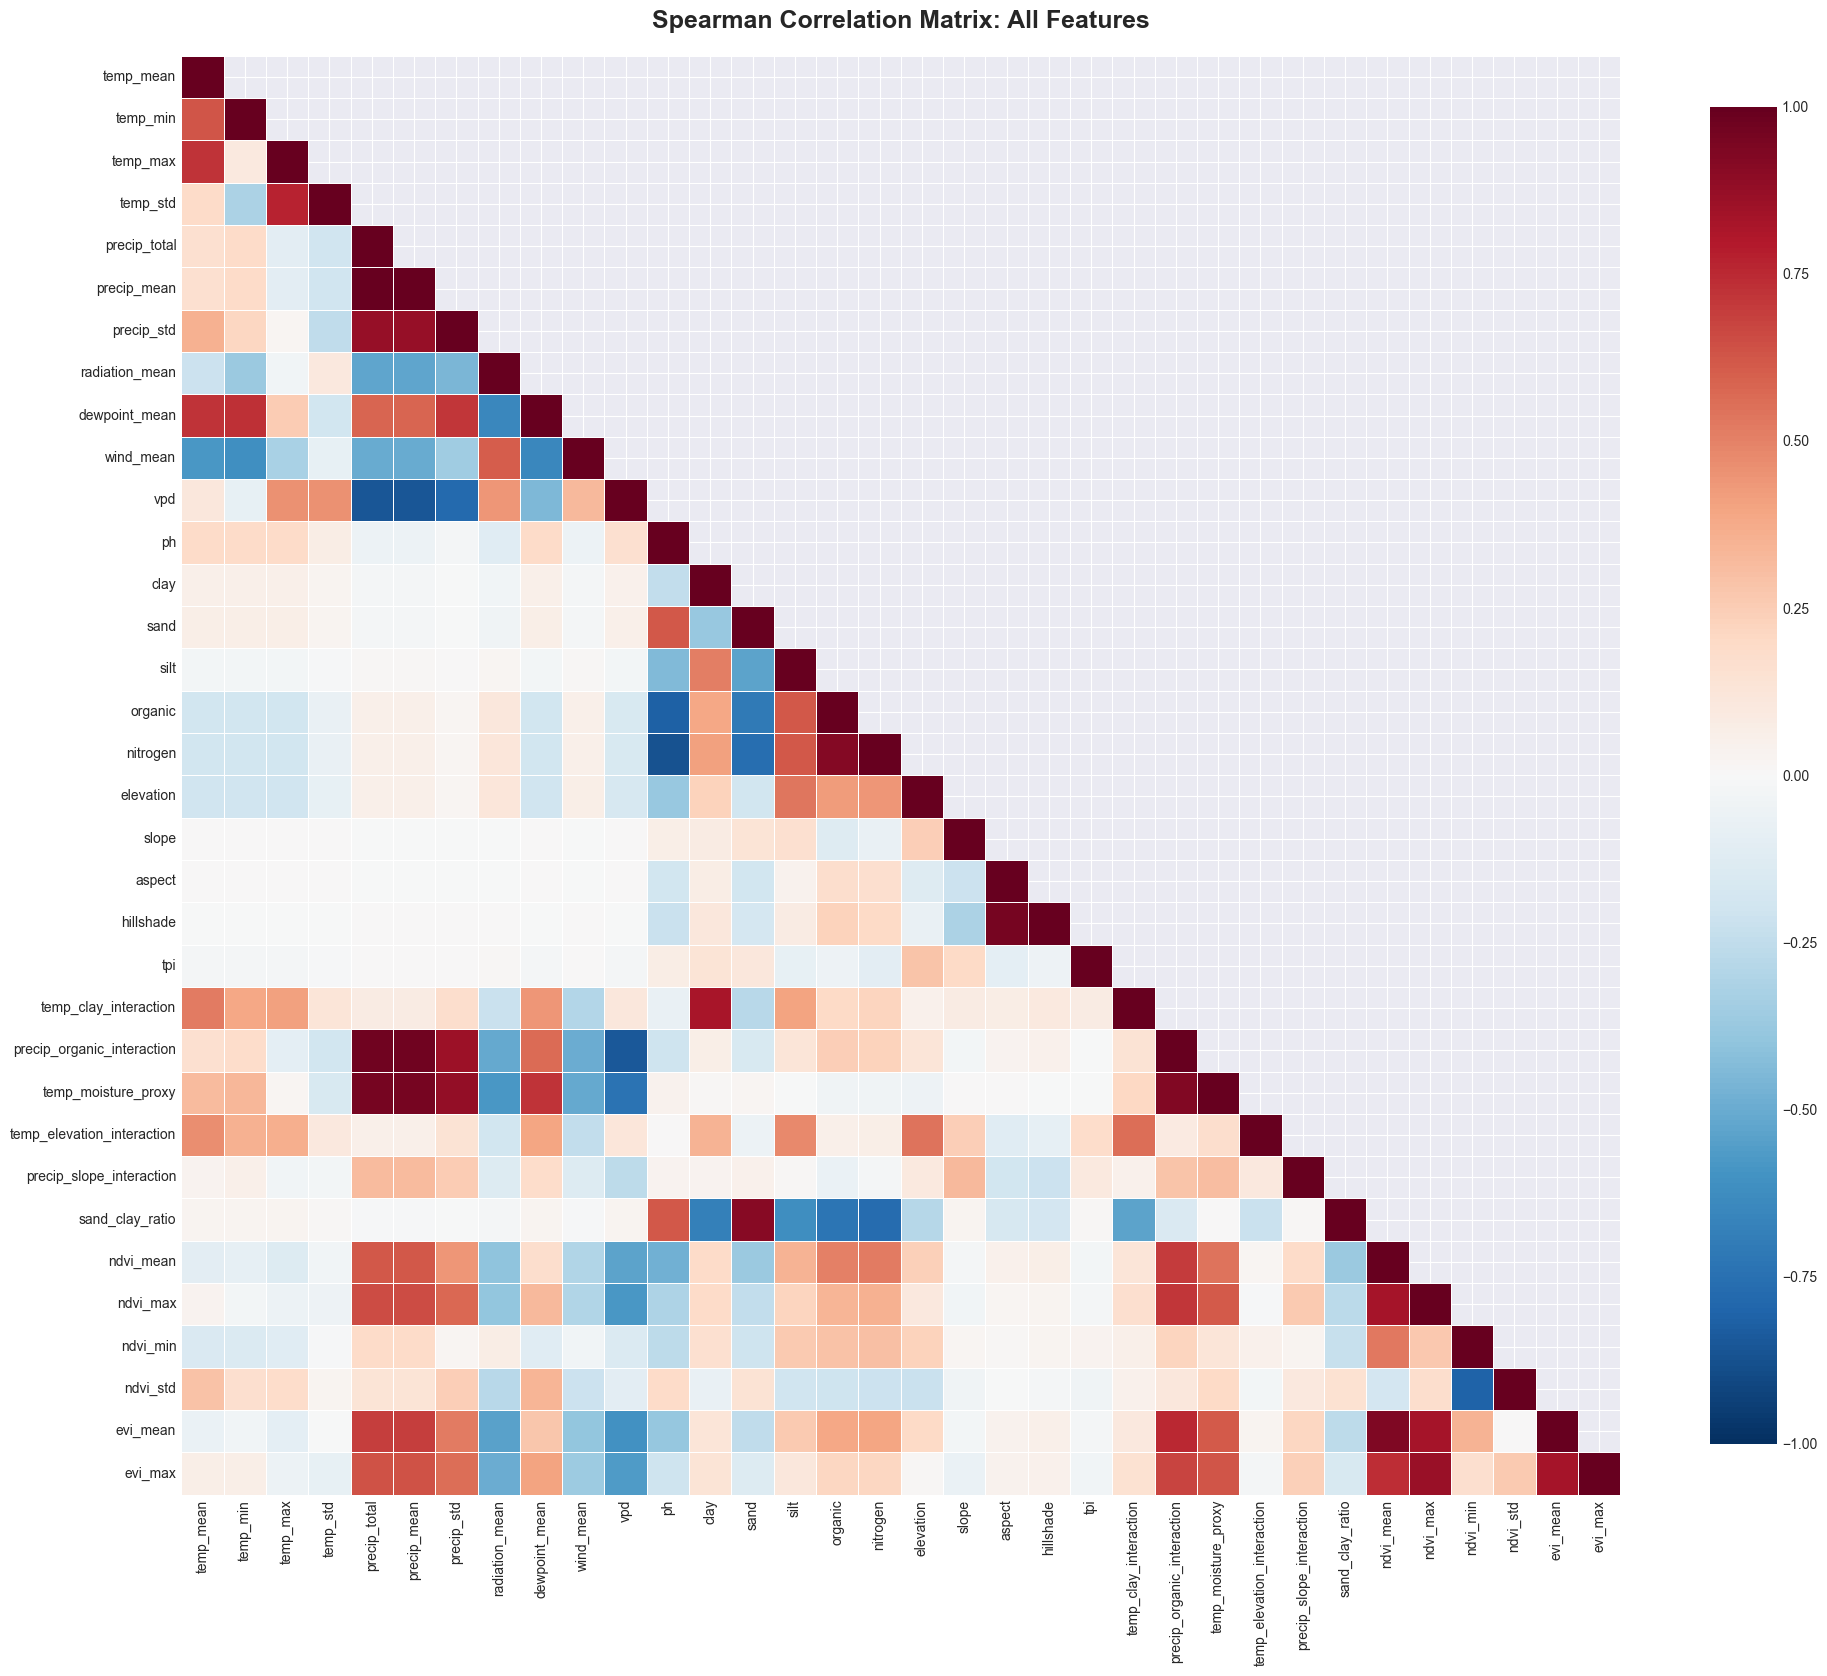

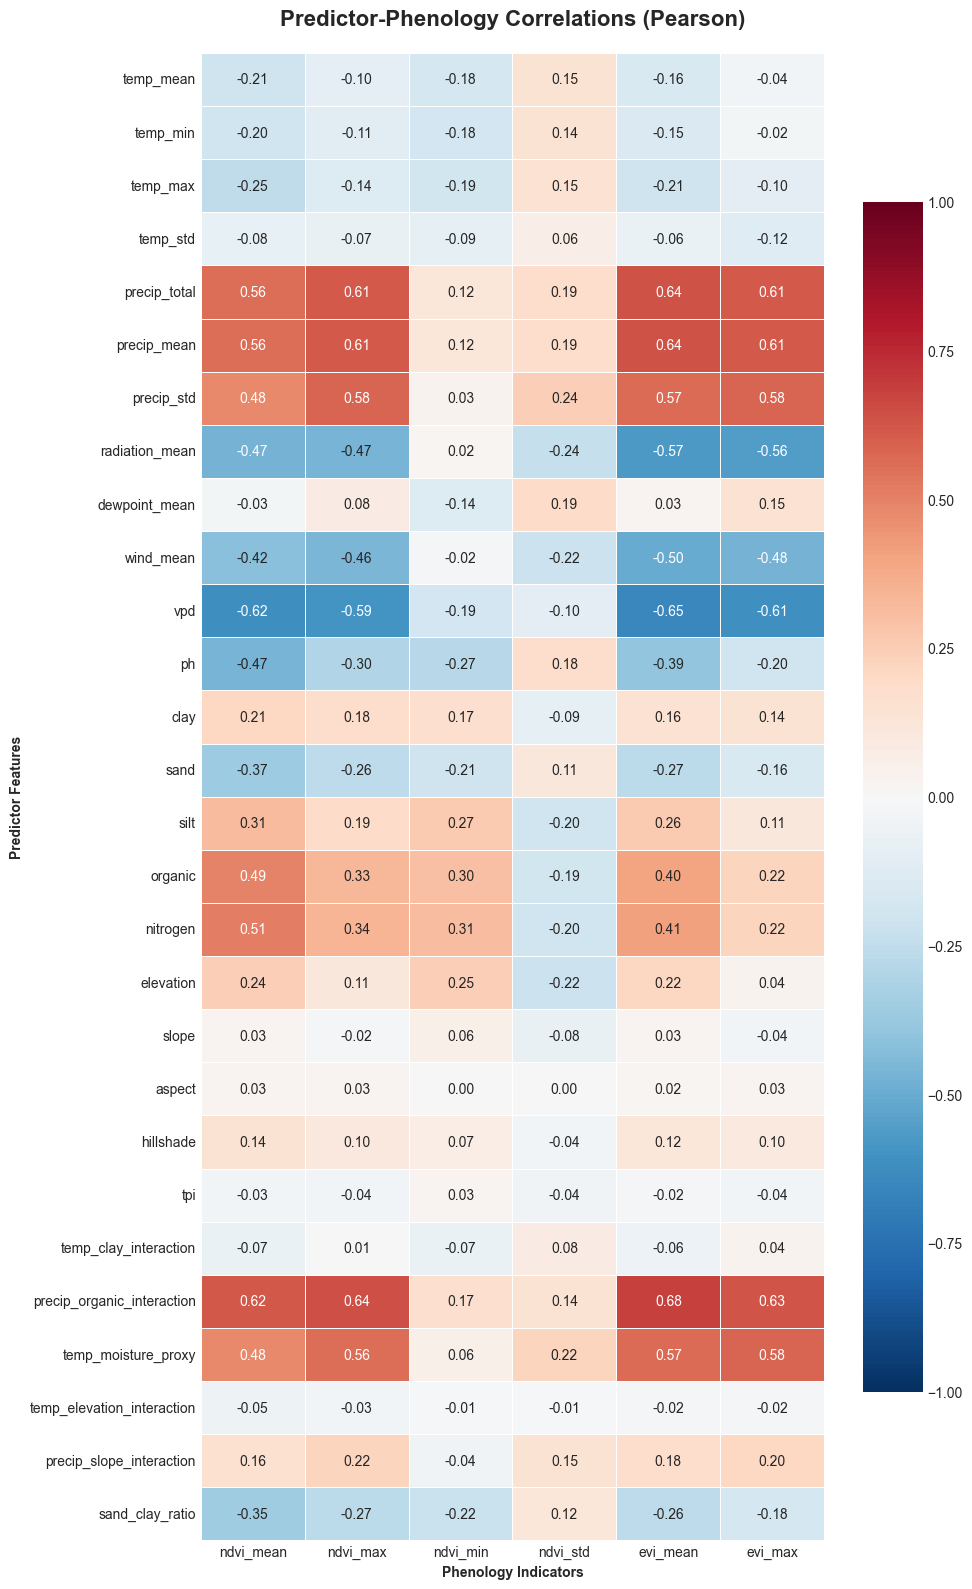

In [4]:
# Compute correlation matrices
features_for_corr = ALL_PREDICTORS + PHENOLOGY_FEATURES
corr_pearson = data[features_for_corr].corr(method='pearson')
corr_spearman = data[features_for_corr].corr(method='spearman')

# Plot Pearson correlation matrix
fig, ax = plt.subplots(figsize=(20, 18))
mask = np.triu(np.ones_like(corr_pearson, dtype=bool), k=1)
sns.heatmap(corr_pearson, mask=mask, annot=False, fmt='.2f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Pearson Correlation Matrix: All Features', 
             fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./data_output/eda_correlation_pearson_full.png', dpi=300, bbox_inches='tight')
print("✅ Pearson correlation matrix plotted")

# Plot Spearman correlation matrix
fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(corr_spearman, mask=mask, annot=False, fmt='.2f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Spearman Correlation Matrix: All Features', 
             fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./data_output/eda_correlation_spearman_full.png', dpi=300, bbox_inches='tight')
print("✅ Spearman correlation matrix plotted")

# Focused correlation: Predictors vs Phenology
phenology_corr = corr_pearson.loc[ALL_PREDICTORS, PHENOLOGY_FEATURES]

fig, ax = plt.subplots(figsize=(10, 16))
sns.heatmap(phenology_corr, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Predictor-Phenology Correlations (Pearson)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Phenology Indicators', fontweight='bold')
ax.set_ylabel('Predictor Features', fontweight='bold')
plt.tight_layout()
plt.savefig('./data_output/eda_correlation_phenology_focused.png', dpi=300, bbox_inches='tight')
print("✅ Predictor-Phenology correlation plotted")

# Top correlations with target
target_corr = corr_pearson[TARGET_VARIABLE].sort_values(ascending=False)
print(f"\n📊 Top 15 correlations with {TARGET_VARIABLE}:")
print(target_corr.head(16)[1:])  # Exclude self-correlation

#### ============================================================================
<h3 align="center">SECTION 4: SPATIAL VISUALIZATION</h3>

#### ============================================================================

✅ Spatial plot created: ndvi_max
✅ Spatial plot created: temp_mean
✅ Spatial plot created: precip_total
✅ Spatial plot created: elevation
✅ Spatial plot created: clay
✅ Spatial plot created: organic
✅ Multi-panel spatial visualization created


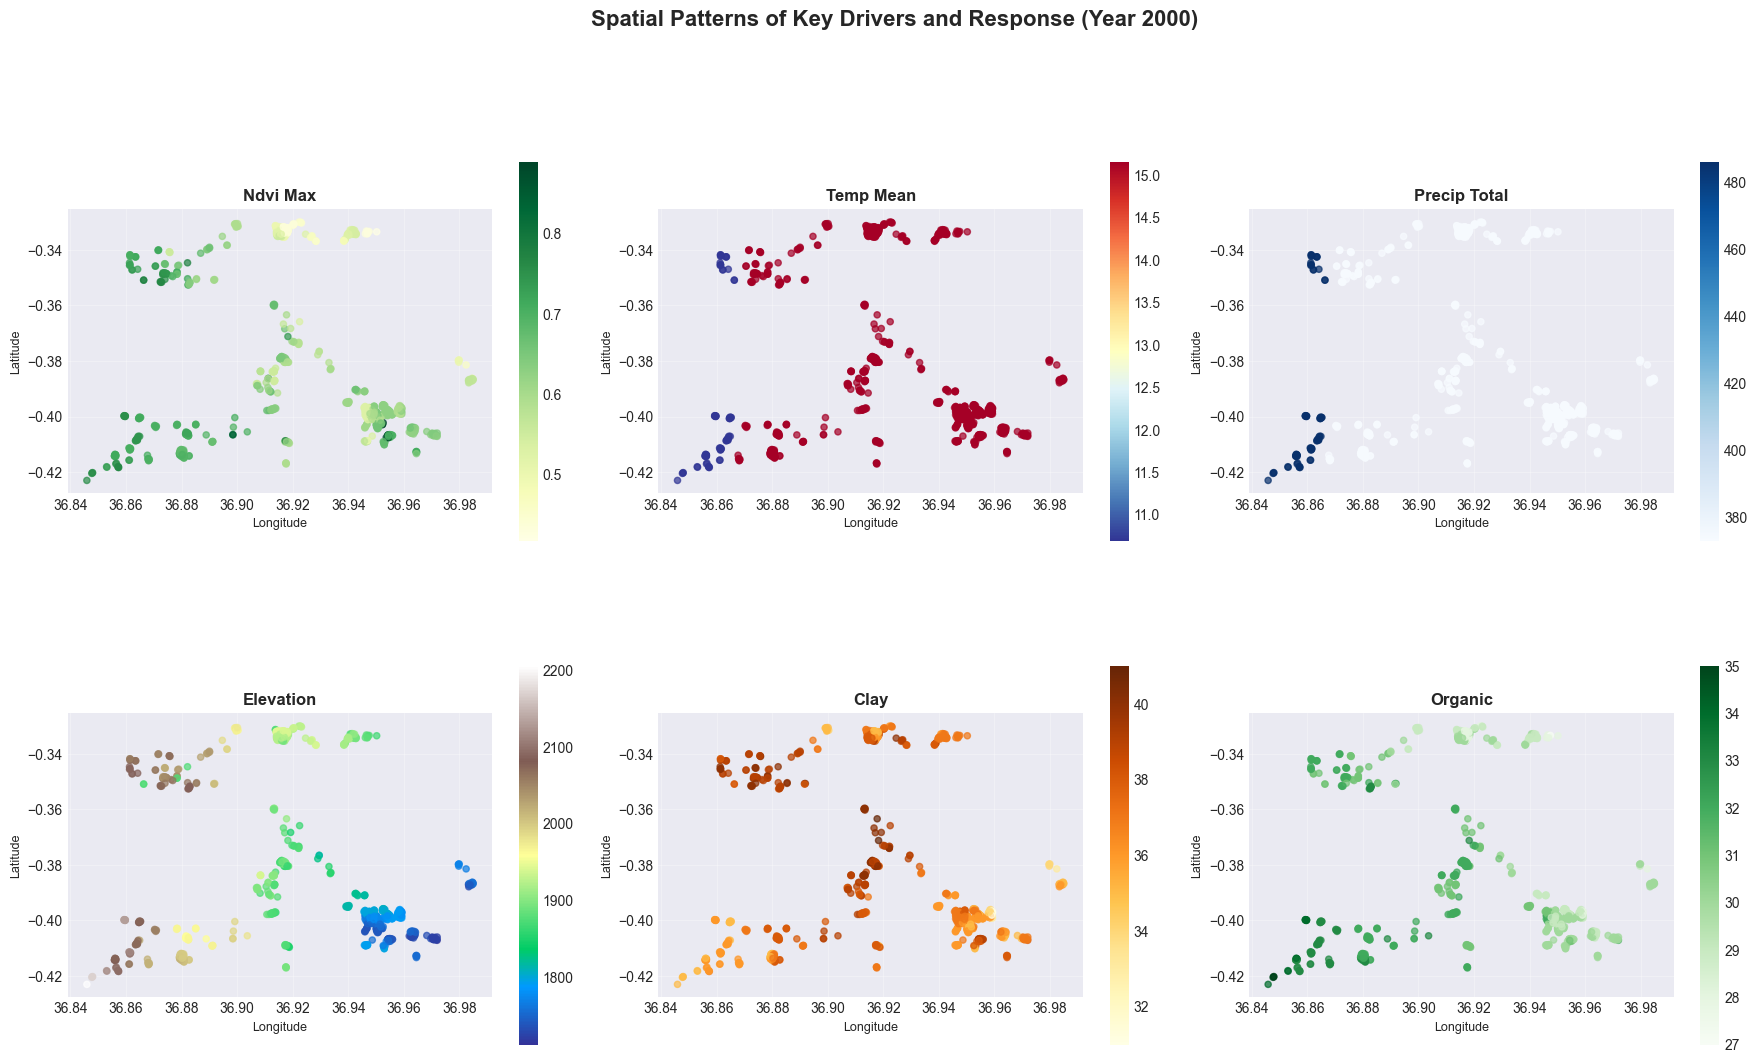

In [5]:
# Create GeoDataFrame for spatial analysis
gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.longitude, data.latitude),
    crs='EPSG:4326'
)

# Select representative year for spatial plotting
year_to_plot = data['year'].mode()[0]
gdf_year = gdf[gdf['year'] == year_to_plot].copy()

def plot_spatial_pattern(gdf, feature, title, cmap='viridis'):
    """Create spatial plot for a feature"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    gdf.plot(column=feature, ax=ax, legend=True,
             cmap=cmap, markersize=30, alpha=0.7,
             legend_kwds={'label': feature, 'shrink': 0.6})
    
    ax.set_title(f'{title}\n(Year: {year_to_plot})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude', fontweight='bold')
    ax.set_ylabel('Latitude', fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    return fig

# Plot key spatial patterns
spatial_features = {
    'ndvi_max': ('NDVI Maximum - Phenology Response', 'YlGn'),
    'temp_mean': ('Mean Temperature (°C)', 'RdYlBu_r'),
    'precip_total': ('Total Precipitation (mm)', 'Blues'),
    'elevation': ('Elevation (m)', 'terrain'),
    'clay': ('Clay Content (%)', 'YlOrBr'),
    'organic': ('Organic Carbon (g/kg)', 'Greens')
}

for feature, (title, cmap) in spatial_features.items():
    fig = plot_spatial_pattern(gdf_year, feature, title, cmap)
    plt.savefig(f'./data_output/eda_spatial_{feature}.png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✅ Spatial plot created: {feature}")

# Multi-panel spatial comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

features_multi = ['ndvi_max', 'temp_mean', 'precip_total', 
                  'elevation', 'clay', 'organic']
cmaps = ['YlGn', 'RdYlBu_r', 'Blues', 'terrain', 'YlOrBr', 'Greens']

for idx, (feature, cmap) in enumerate(zip(features_multi, cmaps)):
    gdf_year.plot(column=feature, ax=axes[idx], 
                  cmap=cmap, markersize=20, alpha=0.7,
                  legend=True, legend_kwds={'shrink': 0.6})
    axes[idx].set_title(feature.replace('_', ' ').title(), fontweight='bold')
    axes[idx].set_xlabel('Longitude', fontsize=9)
    axes[idx].set_ylabel('Latitude', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle(f'Spatial Patterns of Key Drivers and Response (Year {year_to_plot})',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('./data_output/eda_spatial_multipanel.png', dpi=300, bbox_inches='tight')
print("✅ Multi-panel spatial visualization created")

#### ============================================================================
<h3 align="center">SECTION 5: MULTI-SCALE TEMPORAL PATTERNS</h3>

#### ============================================================================

✅ Temporal trends plotted


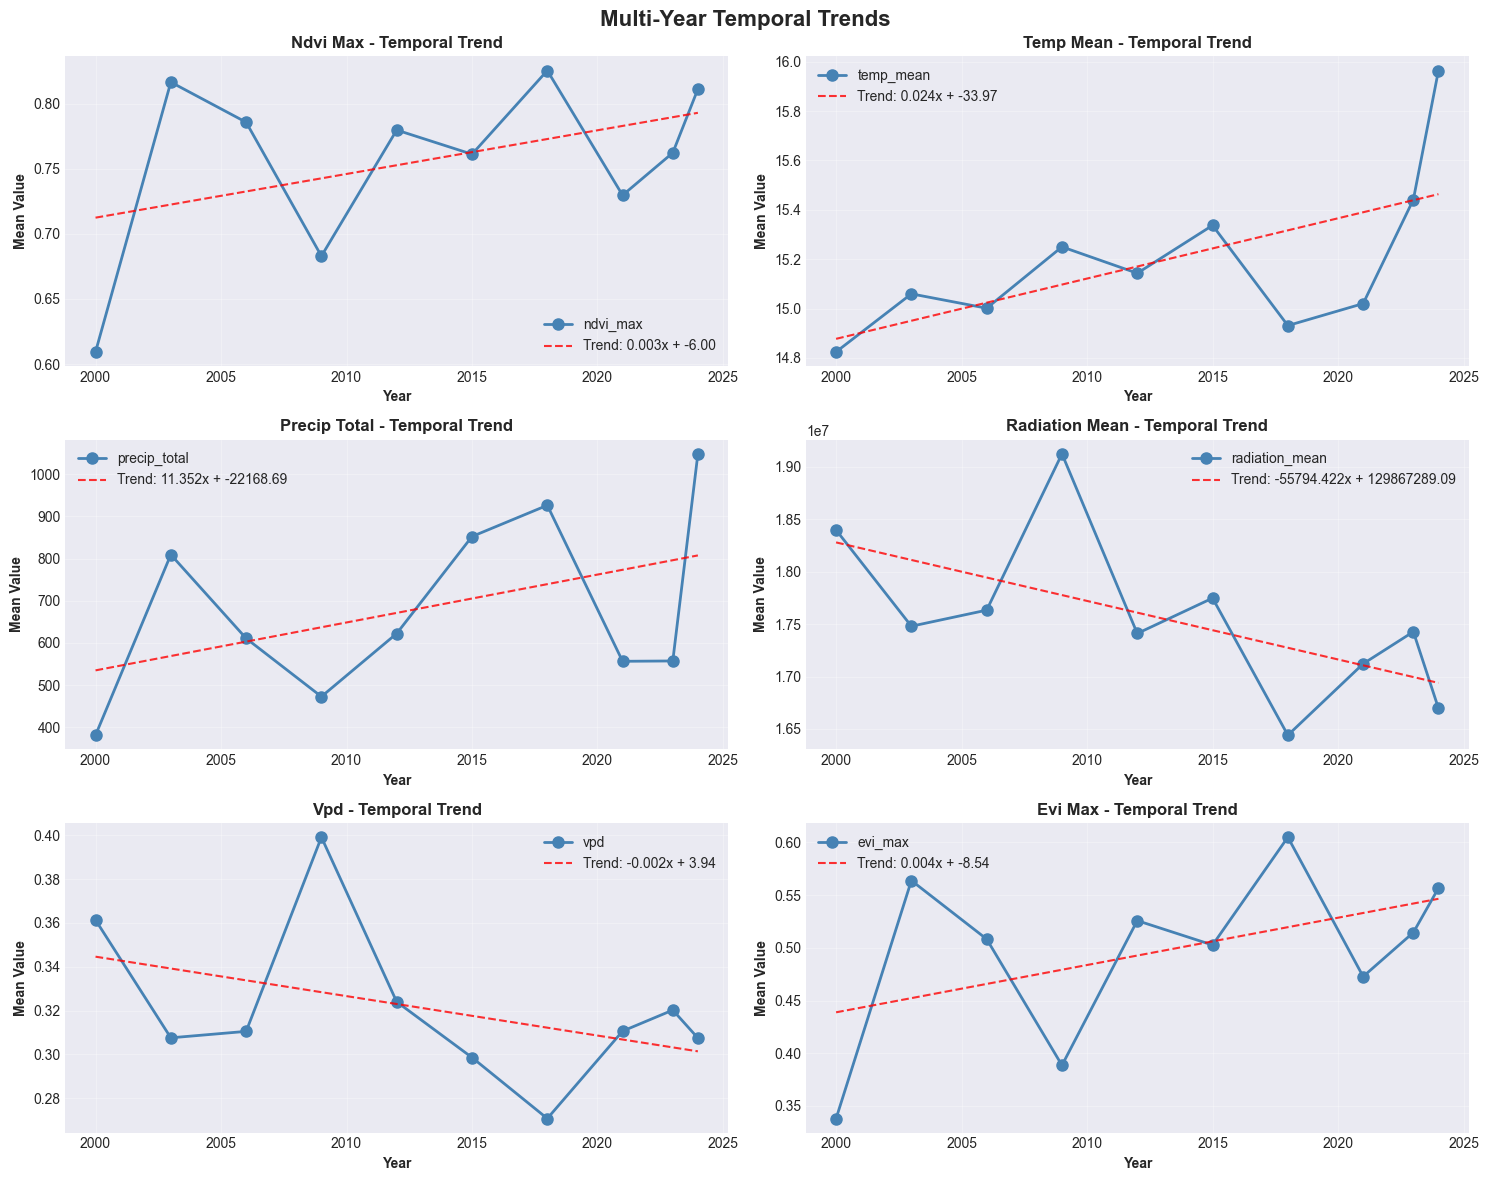

In [6]:
# Aggregate by year to see temporal trends
yearly_means = data.groupby('year')[PHENOLOGY_FEATURES + CLIMATE_FEATURES].mean()

# Plot temporal trends
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

temporal_features = ['ndvi_max', 'temp_mean', 'precip_total', 
                     'radiation_mean', 'vpd', 'evi_max']

for idx, feature in enumerate(temporal_features):
    ax = axes[idx]
    yearly_means[feature].plot(ax=ax, marker='o', linewidth=2, 
                                markersize=8, color='steelblue')
    ax.set_title(f'{feature.replace("_", " ").title()} - Temporal Trend',
                 fontweight='bold')
    ax.set_xlabel('Year', fontweight='bold')
    ax.set_ylabel('Mean Value', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add trend line
    years = yearly_means.index.values
    values = yearly_means[feature].values
    z = np.polyfit(years, values, 1)
    p = np.poly1d(z)
    ax.plot(years, p(years), "r--", alpha=0.8, 
            label=f'Trend: {z[0]:.3f}x + {z[1]:.2f}')
    ax.legend()

plt.suptitle('Multi-Year Temporal Trends', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('./data_output/eda_temporal_trends.png', dpi=300, bbox_inches='tight')
print("✅ Temporal trends plotted")

#### ============================================================================
<h3 align="center">SECTION 6: FEATURE IMPORTANCE (Random Forest Baseline)</h3>

#### ============================================================================

✅ Feature importance plotted

📊 Top 10 most important features:
                       Feature  Importance
23  precip_organic_interaction    0.655839
16                    nitrogen    0.046282
11                          ph    0.045133
17                   elevation    0.042799
25  temp_elevation_interaction    0.037005
6                   precip_std    0.031114
27             sand_clay_ratio    0.025843
1                     temp_min    0.025684
21                         tpi    0.015752
22       temp_clay_interaction    0.015442


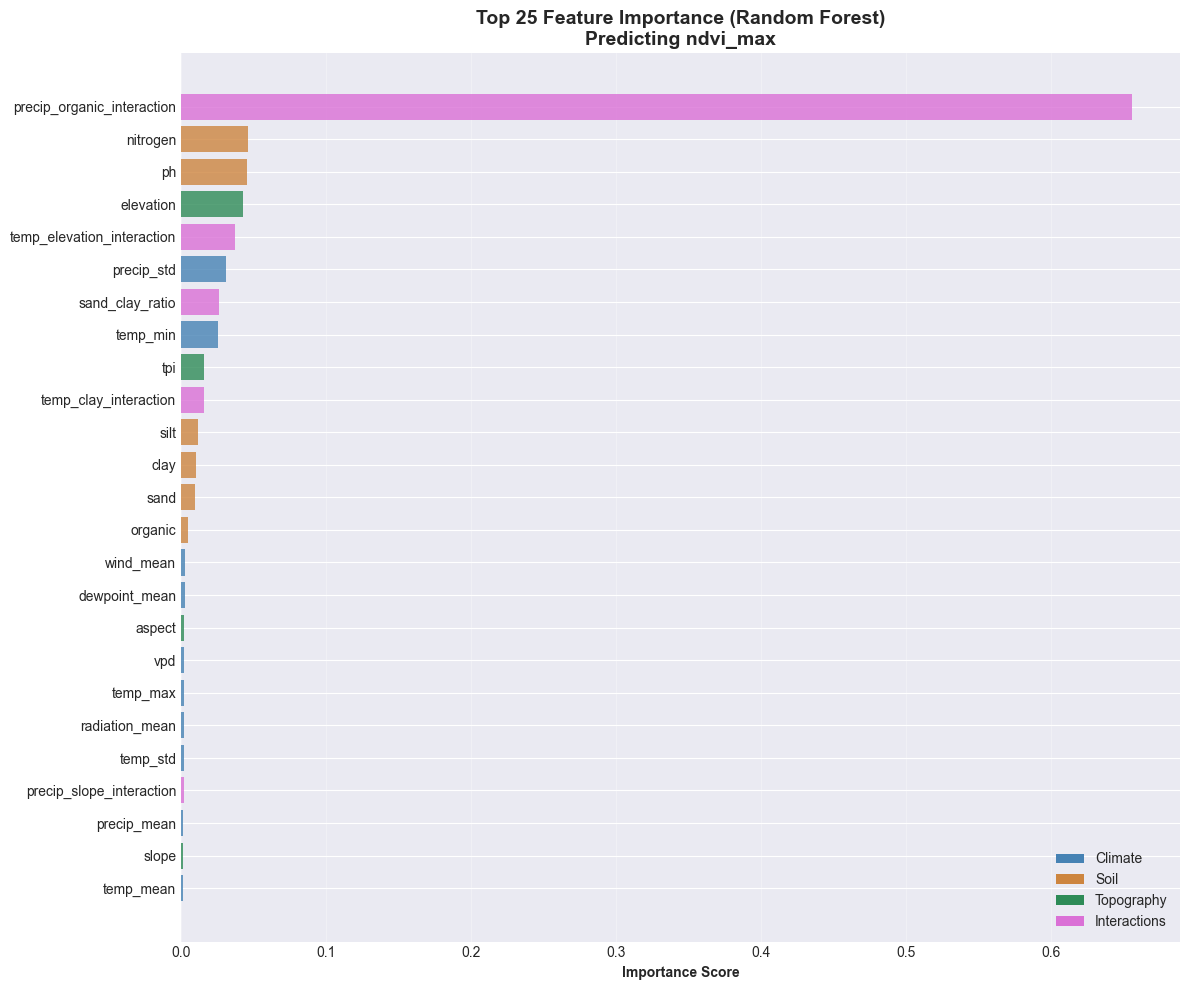

In [7]:
# Prepare data for Random Forest
X = data[ALL_PREDICTORS].copy()
y = data[TARGET_VARIABLE].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=ALL_PREDICTORS)

# Train Random Forest for feature importance
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, 
                                 random_state=42, n_jobs=-1)
rf_model.fit(X_scaled, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': ALL_PREDICTORS,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 10))
top_n = 25
top_features = feature_importance.head(top_n)

colors = []
for feat in top_features['Feature']:
    if feat in CLIMATE_FEATURES:
        colors.append('steelblue')
    elif feat in SOIL_FEATURES:
        colors.append('peru')
    elif feat in TOPO_FEATURES:
        colors.append('seagreen')
    else:
        colors.append('orchid')

ax.barh(range(top_n), top_features['Importance'], color=colors, alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance Score', fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importance (Random Forest)\nPredicting {TARGET_VARIABLE}',
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Climate'),
    Patch(facecolor='peru', label='Soil'),
    Patch(facecolor='seagreen', label='Topography'),
    Patch(facecolor='orchid', label='Interactions')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('./data_output/eda_feature_importance_rf.png', dpi=300, bbox_inches='tight')
print("✅ Feature importance plotted")
print(f"\n📊 Top 10 most important features:")
print(feature_importance.head(10))

#### ============================================================================
<h3 align="center">SECTION 7: MUTUAL INFORMATION (Non-linear dependencies)</h3>

#### ============================================================================

✅ Mutual information plotted

📊 Top 10 features by mutual information:
                       Feature  MI_Score
25  temp_elevation_interaction  4.344830
23  precip_organic_interaction  3.024344
22       temp_clay_interaction  2.982679
17                   elevation  2.629651
21                         tpi  2.539710
27             sand_clay_ratio  2.199574
10                         vpd  2.060756
2                     temp_max  2.058511
7               radiation_mean  2.056059
0                    temp_mean  2.055321


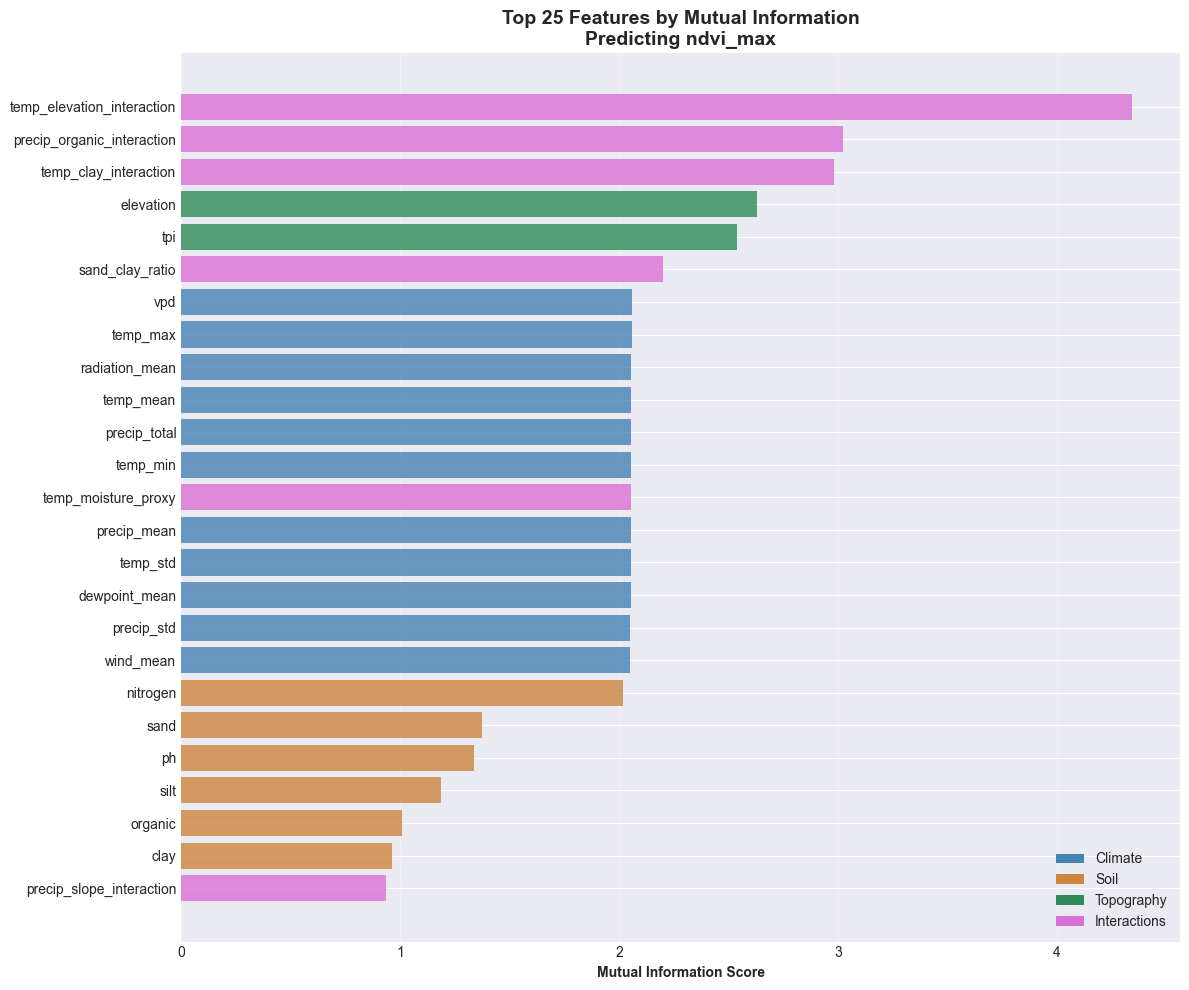

In [8]:
# Calculate mutual information
mi_scores = mutual_info_regression(X_scaled, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': ALL_PREDICTORS,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

# Plot mutual information
fig, ax = plt.subplots(figsize=(12, 10))
top_n_mi = 25
top_mi = mi_df.head(top_n_mi)

colors_mi = []
for feat in top_mi['Feature']:
    if feat in CLIMATE_FEATURES:
        colors_mi.append('steelblue')
    elif feat in SOIL_FEATURES:
        colors_mi.append('peru')
    elif feat in TOPO_FEATURES:
        colors_mi.append('seagreen')
    else:
        colors_mi.append('orchid')

ax.barh(range(top_n_mi), top_mi['MI_Score'], color=colors_mi, alpha=0.8)
ax.set_yticks(range(top_n_mi))
ax.set_yticklabels(top_mi['Feature'])
ax.set_xlabel('Mutual Information Score', fontweight='bold')
ax.set_title(f'Top {top_n_mi} Features by Mutual Information\nPredicting {TARGET_VARIABLE}',
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('./data_output/eda_mutual_information.png', dpi=300, bbox_inches='tight')
print("✅ Mutual information plotted")
print(f"\n📊 Top 10 features by mutual information:")
print(mi_df.head(10))

#### ============================================================================
<h3 align="center">SECTION 8: PCA FOR DIMENSIONALITY EXPLORATION</h3>

#### ============================================================================

✅ PCA analysis complete
   Components for 80% variance: 6
   Components for 90% variance: 9


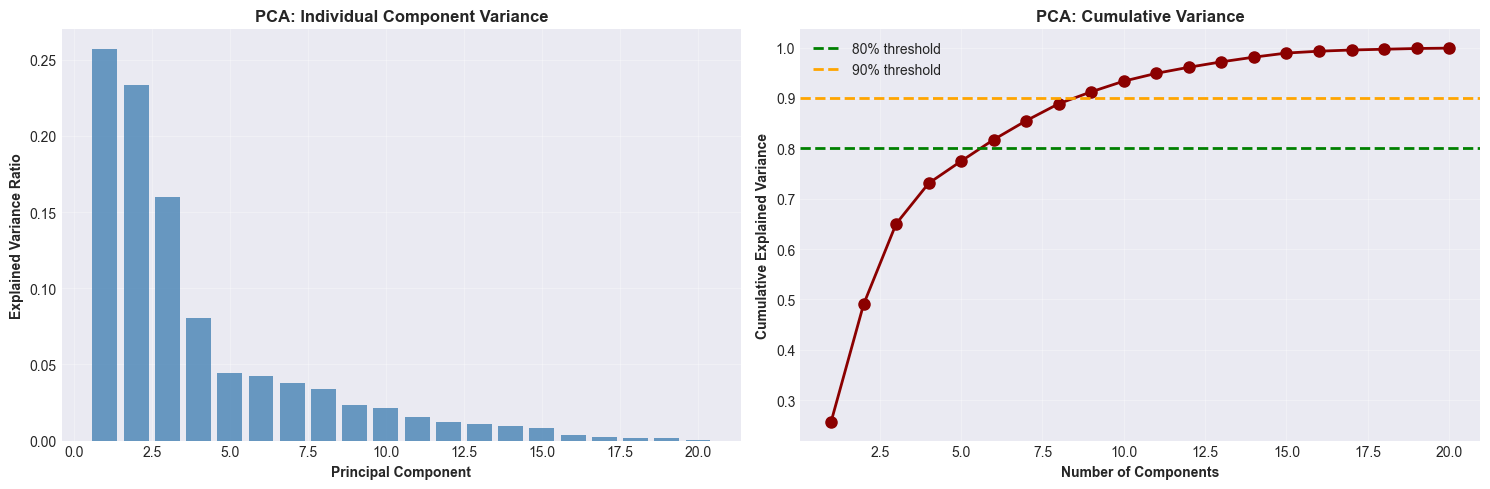

In [9]:
# Perform PCA
pca = PCA(n_components=min(20, len(ALL_PREDICTORS)))
pca_components = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var)

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Individual variance
ax1.bar(range(1, len(explained_var)+1), explained_var, 
        color='steelblue', alpha=0.8)
ax1.set_xlabel('Principal Component', fontweight='bold')
ax1.set_ylabel('Explained Variance Ratio', fontweight='bold')
ax1.set_title('PCA: Individual Component Variance', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, len(cumsum_var)+1), cumsum_var, 
         marker='o', linewidth=2, markersize=8, color='darkred')
ax2.axhline(y=0.8, color='green', linestyle='--', 
            label='80% threshold', linewidth=2)
ax2.axhline(y=0.9, color='orange', linestyle='--', 
            label='90% threshold', linewidth=2)
ax2.set_xlabel('Number of Components', fontweight='bold')
ax2.set_ylabel('Cumulative Explained Variance', fontweight='bold')
ax2.set_title('PCA: Cumulative Variance', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./data_output/eda_pca_variance.png', dpi=300, bbox_inches='tight')
print(f"✅ PCA analysis complete")
print(f"   Components for 80% variance: {np.argmax(cumsum_var >= 0.8) + 1}")
print(f"   Components for 90% variance: {np.argmax(cumsum_var >= 0.9) + 1}")

#### ============================================================================
<h3 align="center"> SECTION 9: INTERACTION DETECTION VIA SCATTER PLOTS</h3>

#### ============================================================================

✅ Scatter matrix created


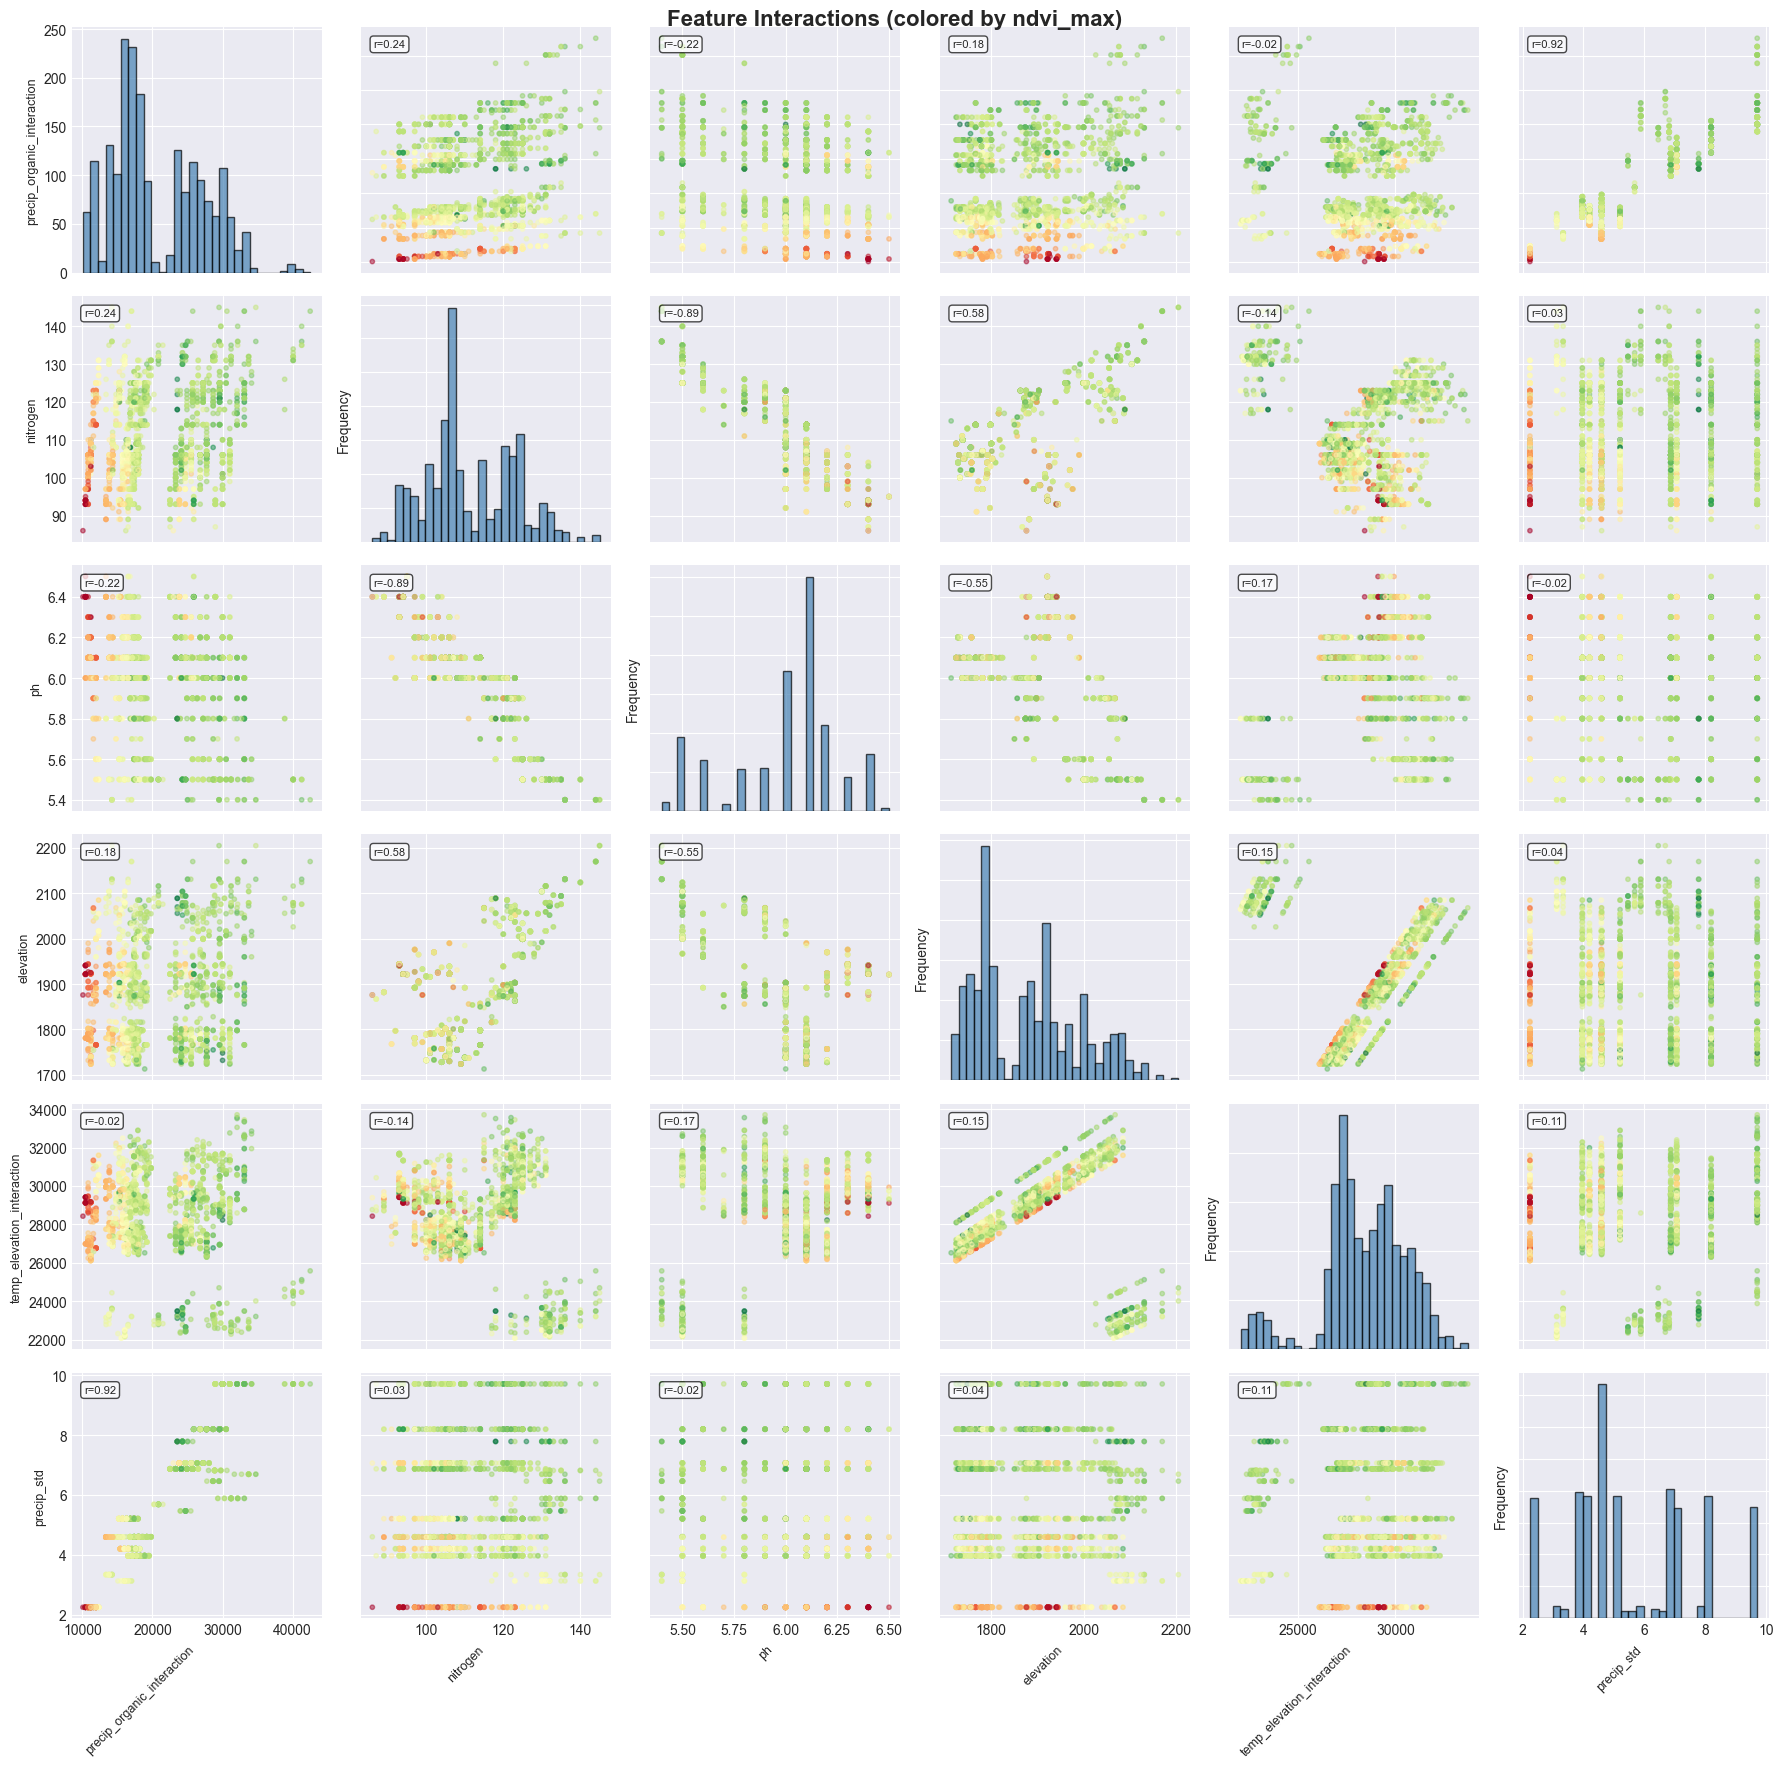

In [10]:
# Select top features from correlation and MI analysis
top_features_for_scatter = feature_importance.head(6)['Feature'].tolist()

# Create scatter matrix
sample_data = data.sample(n=min(2000, len(data)), random_state=42)

fig = plt.figure(figsize=(18, 18))
axes = []

n_features = len(top_features_for_scatter)
for i, feat1 in enumerate(top_features_for_scatter):
    for j, feat2 in enumerate(top_features_for_scatter):
        ax = plt.subplot(n_features, n_features, i*n_features + j + 1)
        
        if i == j:
            # Diagonal: distribution
            ax.hist(sample_data[feat1], bins=30, 
                   color='steelblue', alpha=0.7, edgecolor='black')
            ax.set_ylabel('Frequency')
        else:
            # Off-diagonal: scatter with phenology color-coding
            scatter = ax.scatter(sample_data[feat2], sample_data[feat1],
                                c=sample_data[TARGET_VARIABLE],
                                cmap='RdYlGn', alpha=0.5, s=10)
            
            # Add correlation coefficient
            corr_val = sample_data[[feat1, feat2]].corr().iloc[0, 1]
            ax.text(0.05, 0.95, f'r={corr_val:.2f}',
                   transform=ax.transAxes, fontsize=8,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        if i == n_features - 1:
            ax.set_xlabel(feat2, fontsize=9, rotation=45, ha='right')
        else:
            ax.set_xticklabels([])
        
        if j == 0:
            ax.set_ylabel(feat1, fontsize=9)
        else:
            ax.set_yticklabels([])

plt.suptitle(f'Feature Interactions (colored by {TARGET_VARIABLE})',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('./data_output/eda_scatter_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Scatter matrix created")

#### ============================================================================
<h3 align="center">FINAL SUMMARY</h3>

#### ============================================================================

In [11]:
summary_stats = {
    'Total Observations': len(data),
    'Unique Locations': data['index'].nunique(),
    'Years Analyzed': len(data['year'].unique()),
    'Total Features': len(ALL_PREDICTORS),
    'Climate Features': len(CLIMATE_FEATURES),
    'Soil Features': len(SOIL_FEATURES),
    'Topographic Features': len(TOPO_FEATURES),
    'Interaction Features': len(INTERACTION_FEATURES),
    'Target Variable': TARGET_VARIABLE,
    'Target Mean': f"{data[TARGET_VARIABLE].mean():.4f}",
    'Target Std': f"{data[TARGET_VARIABLE].std():.4f}",
    'Top Feature (RF)': feature_importance.iloc[0]['Feature'],
    'Top Feature Importance': f"{feature_importance.iloc[0]['Importance']:.4f}",
    'Top Feature (MI)': mi_df.iloc[0]['Feature'],
    'Top MI Score': f"{mi_df.iloc[0]['MI_Score']:.4f}"
}

print("\n📊 Key Statistics:")
for key, value in summary_stats.items():
    print(f"   {key}: {value}")

# Save summary report
with open('./data_output/eda_summary_report.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("EXPLORATORY DATA ANALYSIS - SUMMARY REPORT\n")
    f.write("="*70 + "\n\n")
    
    for key, value in summary_stats.items():
        f.write(f"{key}: {value}\n")
    
    f.write("\n" + "="*70 + "\n")
    f.write("TOP 10 FEATURES BY RANDOM FOREST IMPORTANCE\n")
    f.write("="*70 + "\n")
    f.write(feature_importance.head(10).to_string())
    
    f.write("\n\n" + "="*70 + "\n")
    f.write("TOP 10 FEATURES BY MUTUAL INFORMATION\n")
    f.write("="*70 + "\n")
    f.write(mi_df.head(10).to_string())
    
    f.write("\n\n" + "="*70 + "\n")
    f.write(f"TOP 15 CORRELATIONS WITH {TARGET_VARIABLE}\n")
    f.write("="*70 + "\n")
    f.write(target_corr.head(16)[1:].to_string())

print("\n✅ EDA complete! All outputs saved to ./data_output/")
print("\nGenerated files:")
print("  - eda_*.png (visualization plots)")
print("  - eda_summary_report.txt (statistical summary)")
print("\n" + "="*70)


📊 Key Statistics:
   Total Observations: 10000
   Unique Locations: 1000
   Years Analyzed: 10
   Total Features: 28
   Climate Features: 11
   Soil Features: 6
   Topographic Features: 5
   Interaction Features: 6
   Target Variable: ndvi_max
   Target Mean: 0.7563
   Target Std: 0.0850
   Top Feature (RF): precip_organic_interaction
   Top Feature Importance: 0.6558
   Top Feature (MI): temp_elevation_interaction
   Top MI Score: 4.3448

✅ EDA complete! All outputs saved to ./data_output/

Generated files:
  - eda_*.png (visualization plots)
  - eda_summary_report.txt (statistical summary)

